# Esercitazione 11

## Esercizio 2

Definisco la funzione polinomiale da predire:
$$
f(x)=4-3x-2x^2+3x^3
$$

Nel generare i dati con rumore stocastico, pongo $\sigma = 0.5$. Genero due serie di dati di validazione: la prima cade nell'intervallo usato per il training, ovvero $[-1,1]$ la seconda invece copre  l'intervallo successivo: $[1,3]$. Valuterò poi se il modello ha un comportamento peggiore nel secondo caso.

In [15]:
import numpy as np

def polynomial (x):
    a = 4 
    b = -3
    c = -2 
    d = 3
    return a + b*x +c*x**2 + d*x**3

nsamples = 100
nsamples_valid = 30

np.random.seed(278)
x_train = np.random.uniform(-1, 1, nsamples)
x_valid1 = np.random.uniform(-1, 1, nsamples_valid)
x_valid2 = np.random.uniform(1, 2, nsamples_valid)
x_valid1.sort()
x_valid2.sort()
y_target1 = polynomial(x_valid1)
y_target2 = polynomial(x_valid2)

sigma = 0.5 # noise standard deviation, 
y_train = np.random.normal(polynomial(x_train), sigma) 
y_valid1 = np.random.normal(polynomial(x_valid1), sigma)
y_valid2 = np.random.normal(polynomial(x_valid2), sigma)

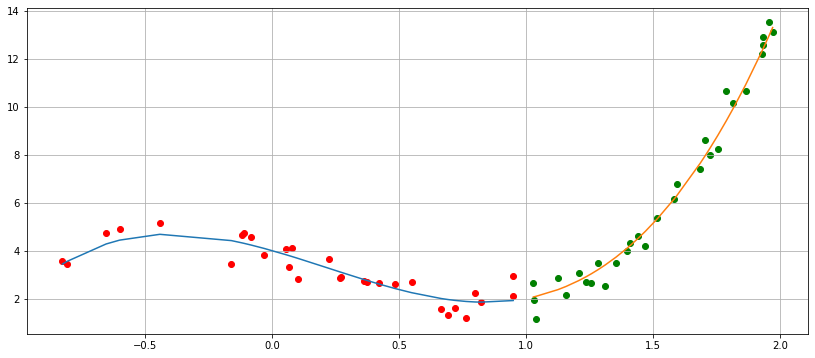

In [16]:
# plot training and target dataset
import matplotlib.pyplot as plt

plt.figure(figsize = (14,6))
plt.plot(x_valid1, y_target1)
plt.scatter(x_valid1, y_valid1, color='r')
plt.plot(x_valid2, y_target2)
plt.scatter(x_valid2, y_valid2, color='g')
plt.grid(True); 
plt.show()

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
import matplotlib.pyplot as plt

### Ottimizzazione dei parametri

Creo ora la rete neurale. Vario i diversi parametri della rete neurale:
- il numero di layers
- il numero di neuroni per ogni layer
- la funzione di attivazione
- l'ottimizzatore
- la funzione di costo

Utilizzo il set di validazione per valutare le performance delle diverse reti, e salvo la migliore ottenuta da questa ampia grid search. Eseguo separamente l'analisi utilizzando come loss function prima un Mean Squared Error e poi un Mean Absolute Error, poichè non posso confrontarli direttamente. 

Per ogni NN, genero dei valori casuali di x e rappresento le y predette nell'intervallo designato [-1,1] e in un intervallo successivo [1,2]. 

In [ ]:
# LOSS = MSE
# parameters to vary
layers = [3,5,10]
neurons = [30,50,80,100,200]
activation = ['tanh', 'relu', 'elu', 'sigmoid', 'softmax'] 
optimizers = ['sgd', 'Adam', 'Adagrad', 'RMSprop']
lossfuncs = ['mse']
nepochs = 200 #using earlystop, so not a problem

nplots = len(layers)*len(neurons)*len(activation)*len(optimizers)*len(lossfuncs)
print (nplots, ' options explored')

# prepare plots
ncols = 3
nrows = int (nplots/ncols)
fig_fit, axs = plt.subplots(nrows, ncols, figsize=(15, 3*nrows), tight_layout=True)

i = 0 #just and index for the subplots
best_score = 1e5 #store info for the best fit

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                  min_delta=0, patience=30, verbose=0, mode='auto')

for my_loss in lossfuncs:
    for n_neurons in neurons:
        for my_activation in activation:
            for my_optimizer in optimizers:
                for nlayers in (layers):
                    title = 'Nlayer='+ str(nlayers) +' Nneur='+ str(n_neurons)+' act='+my_activation+' opt='+my_optimizer+' loss='+my_loss
                    print ('------------------- Progression: %.2f' %(i/nplots*100.), '%')
                    print ('This is:',title)
                    model = tf.keras.Sequential()
                    for j in range (nlayers-1):
                        if (j==0):
                            model.add(Dense(n_neurons, activation = "linear", input_shape=(1,))) 
                        else:
                            model.add(Dense(n_neurons, activation = my_activation))
                    model.add(Dense(1, activation="relu" ))  #final layer
                    model.compile(optimizer=my_optimizer, loss=my_loss, metrics=['mse'])
                    #model.summary()

                    history = model.fit(x=x_train, y=y_train, 
                              batch_size=32, epochs=nepochs,
                              shuffle=True, # a good idea is to shuffle input before each epoch
                              validation_data=(x_valid1, y_valid1),                      
                              callbacks = [earlystop],
                              verbose = 0)
                    model.get_weights()
                    score = model.evaluate(x_valid1, y_valid1, batch_size=32, verbose=1)                    
                    my_score = score[0]

                    x_predicted = np.random.uniform(-1, 2, nsamples)
                    y_predicted = model.predict(x_predicted)
                    
                    column = int(i/(nrows))
                    row = int(i%(nrows))
                    axs[row, column].set_title(title)
                    axs[row, column].scatter(x_predicted, y_predicted,color='r', label ='prediction')
                    axs[row, column].plot(x_valid1, y_target1, label = 'training interval')
                    axs[row, column].plot(x_valid2, y_target2, label = 'other interval')
                    axs[row, column].grid(True)
                    
                    if (my_score < best_score):
                        best_score = my_score
                        best_layers = nlayers 
                        best_neurons = n_neurons 
                        best_activation = my_activation 
                        best_optimizer = my_optimizer
                        best_loss = my_loss
                        best_title = title
                        best_x = x_predicted
                        best_y = y_predicted
    
                    del (model, y_predicted, history)
                    i = i+1

300  options explored
------------------- Progression: 0.00 %
This is: Nlayer=3 Nneur=30 act=tanh opt=sgd loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 0.3671 - mse: 0.3671
------------------- Progression: 0.33 %
This is: Nlayer=5 Nneur=30 act=tanh opt=sgd loss=mse
1/1 [==============================] - 0s 18ms/step - loss: 0.2739 - mse: 0.2739
------------------- Progression: 0.67 %
This is: Nlayer=10 Nneur=30 act=tanh opt=sgd loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 0.3547 - mse: 0.3547
------------------- Progression: 1.00 %
This is: Nlayer=3 Nneur=30 act=tanh opt=Adam loss=mse
1/1 [==============================] - 0s 18ms/step - loss: 0.3461 - mse: 0.3461
------------------- Progression: 1.33 %
This is: Nlayer=5 Nneur=30 act=tanh opt=Adam loss=mse
1/1 [==============================] - 0s 18ms/step - loss: 0.2489 - mse: 0.2489
------------------- Progression: 1.67 %
This is: Nlayer=10 Nneur=30 act=tanh opt=Adam loss=mse
1/1 [=====

1/1 [==============================] - 0s 18ms/step - loss: 11.2051 - mse: 11.2051
------------------- Progression: 15.67 %
This is: Nlayer=10 Nneur=30 act=sigmoid opt=RMSprop loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 11.2051 - mse: 11.2051
------------------- Progression: 16.00 %
This is: Nlayer=3 Nneur=30 act=softmax opt=sgd loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 1.0349 - mse: 1.0349
------------------- Progression: 16.33 %
This is: Nlayer=5 Nneur=30 act=softmax opt=sgd loss=mse
1/1 [==============================] - 0s 27ms/step - loss: 11.2051 - mse: 11.2051
------------------- Progression: 16.67 %
This is: Nlayer=10 Nneur=30 act=softmax opt=sgd loss=mse
1/1 [==============================] - 0s 22ms/step - loss: 1.2166 - mse: 1.2166
------------------- Progression: 17.00 %
This is: Nlayer=3 Nneur=30 act=softmax opt=Adam loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 2.2444 - mse: 2.2444
----------------

1/1 [==============================] - 0s 19ms/step - loss: 0.3646 - mse: 0.3646
------------------- Progression: 31.00 %
This is: Nlayer=3 Nneur=50 act=elu opt=RMSprop loss=mse
1/1 [==============================] - 0s 20ms/step - loss: 0.4420 - mse: 0.4420
------------------- Progression: 31.33 %
This is: Nlayer=5 Nneur=50 act=elu opt=RMSprop loss=mse
1/1 [==============================] - 0s 18ms/step - loss: 0.3180 - mse: 0.3180
------------------- Progression: 31.67 %
This is: Nlayer=10 Nneur=50 act=elu opt=RMSprop loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 0.2956 - mse: 0.2956
------------------- Progression: 32.00 %
This is: Nlayer=3 Nneur=50 act=sigmoid opt=sgd loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 11.2051 - mse: 11.2051
------------------- Progression: 32.33 %
This is: Nlayer=5 Nneur=50 act=sigmoid opt=sgd loss=mse
1/1 [==============================] - 0s 18ms/step - loss: 1.2323 - mse: 1.2323
------------------- Progre

1/1 [==============================] - 0s 20ms/step - loss: 3.9754 - mse: 3.9754
------------------- Progression: 46.33 %
This is: Nlayer=5 Nneur=80 act=relu opt=Adagrad loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 11.2051 - mse: 11.2051
------------------- Progression: 46.67 %
This is: Nlayer=10 Nneur=80 act=relu opt=Adagrad loss=mse
1/1 [==============================] - 0s 20ms/step - loss: 11.2051 - mse: 11.2051
------------------- Progression: 47.00 %
This is: Nlayer=3 Nneur=80 act=relu opt=RMSprop loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 0.3106 - mse: 0.3106
------------------- Progression: 47.33 %
This is: Nlayer=5 Nneur=80 act=relu opt=RMSprop loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 0.5063 - mse: 0.5063
------------------- Progression: 47.67 %
This is: Nlayer=10 Nneur=80 act=relu opt=RMSprop loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 11.2051 - mse: 11.2051
----------------

1/1 [==============================] - 0s 20ms/step - loss: 0.3217 - mse: 0.3217
------------------- Progression: 61.67 %
This is: Nlayer=10 Nneur=100 act=tanh opt=Adam loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 0.2862 - mse: 0.2862
------------------- Progression: 62.00 %
This is: Nlayer=3 Nneur=100 act=tanh opt=Adagrad loss=mse
1/1 [==============================] - 0s 18ms/step - loss: 0.8297 - mse: 0.8297
------------------- Progression: 62.33 %
This is: Nlayer=5 Nneur=100 act=tanh opt=Adagrad loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 0.4314 - mse: 0.4314
------------------- Progression: 62.67 %
This is: Nlayer=10 Nneur=100 act=tanh opt=Adagrad loss=mse
1/1 [==============================] - 0s 22ms/step - loss: 0.4641 - mse: 0.4641
------------------- Progression: 63.00 %
This is: Nlayer=3 Nneur=100 act=tanh opt=RMSprop loss=mse
1/1 [==============================] - 0s 19ms/step - loss: 0.3022 - mse: 0.3022
------------------- 

1/1 [==============================] - 0s 20ms/step - loss: 11.2051 - mse: 11.2051
------------------- Progression: 77.00 %
This is: Nlayer=3 Nneur=100 act=softmax opt=Adam loss=mse
1/1 [==============================] - 0s 20ms/step - loss: 11.2051 - mse: 11.2051
------------------- Progression: 77.33 %
This is: Nlayer=5 Nneur=100 act=softmax opt=Adam loss=mse
1/1 [==============================] - 0s 21ms/step - loss: 11.2051 - mse: 11.2051
------------------- Progression: 77.67 %
This is: Nlayer=10 Nneur=100 act=softmax opt=Adam loss=mse
1/1 [==============================] - 0s 20ms/step - loss: 3.4986 - mse: 3.4986
------------------- Progression: 78.00 %
This is: Nlayer=3 Nneur=100 act=softmax opt=Adagrad loss=mse
1/1 [==============================] - 0s 18ms/step - loss: 11.2051 - mse: 11.2051
------------------- Progression: 78.33 %
This is: Nlayer=5 Nneur=100 act=softmax opt=Adagrad loss=mse


In [ ]:
print ('The best score achieved is', best_score, ' reached when: ', best_title)
print ('Plotting best result using MSE as loss function')
plt.figure(figsize=[14,6])
plt.title(best_title)
plt.scatter(best_x, best_y,color='r'label ='prediction')
plt.plot(x_valid1, y_target1, label ='training interval')
plt.plot(x_valid2, y_target2, label = 'other interval')
plt.grid(True)

In [ ]:
# LOSS = Mean Abs Error
# parameters to vary
layers = [3,5,10]
neurons = [30,50,80,100,200]
activation = ['tanh', 'relu', 'elu', 'sigmoid', 'softmax'] 
optimizers = ['sgd', 'Adam', 'Adagrad', 'RMSprop']
lossfuncs = ['mean_absolute_error']
nepochs = 200 #using earlystop, so not a problem

nplots = len(layers)*len(neurons)*len(activation)*len(optimizers)*len(lossfuncs)
print (nplots, ' options explored')

# prepare plots
ncols = 3
nrows = int (nplots/ncols)
fig_fit, axs = plt.subplots(nrows, ncols, figsize=(15, 3*nrows), tight_layout=True)

i = 0 #just and index for the subplots
best_score = 1e5 #store info for the best fit

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                  min_delta=0, patience=30, verbose=0, mode='auto')

for my_loss in lossfuncs:
    for n_neurons in neurons:
        for my_activation in activation:
            for my_optimizer in optimizers:
                for nlayers in (layers):
                    title = 'Nlayer='+ str(nlayers) +' Nneur='+ str(n_neurons)+' act='+my_activation+' opt='+my_optimizer+' loss='+my_loss
                    print ('------------------- Progression: %.2f' %(i/nplots*100.), '%')
                    print ('This is:',title)
                    model = tf.keras.Sequential()
                    for j in range (nlayers-1):
                        if (j==0):
                            model.add(Dense(n_neurons, activation = "linear", input_shape=(1,))) 
                        else:
                            model.add(Dense(n_neurons, activation = my_activation))
                    model.add(Dense(1, activation="relu" ))  #final layer
                    model.compile(optimizer=my_optimizer, loss=my_loss, metrics=['mse'])
                    #model.summary()

                    history = model.fit(x=x_train, y=y_train, 
                              batch_size=32, epochs=nepochs,
                              shuffle=True, # a good idea is to shuffle input before each epoch
                              validation_data=(x_valid1, y_valid1),                      
                              callbacks = [earlystop],
                              verbose = 0)
                    model.get_weights()
                    score = model.evaluate(x_valid1, y_valid1, batch_size=32, verbose=1)                    
                    my_score = score[0]

                    x_predicted = np.random.uniform(-1, 2, nsamples)
                    y_predicted = model.predict(x_predicted)
                    
                    column = int(i/(nrows))
                    row = int(i%(nrows))
                    axs[row, column].set_title(title)
                    axs[row, column].scatter(x_predicted, y_predicted,color='r', label ='prediction')
                    axs[row, column].plot(x_valid1, y_target1, label = 'training interval')
                    axs[row, column].plot(x_valid2, y_target2, label = 'other interval')
                    axs[row, column].grid(True)
                    
                    if (my_score < best_score):
                        best_score = my_score
                        best_layers = nlayers 
                        best_neurons = n_neurons 
                        best_activation = my_activation 
                        best_optimizer = my_optimizer
                        best_loss = my_loss
                        best_title = title
                        best_x = x_predicted
                        best_y = y_predicted
    
                    del (model, y_predicted, history)
                    i = i+1

In [ ]:
print ('The best score achieved is', best_score, ' reached when: ', best_title)
print ('Plotting best result using Mean Abs Error as loss function')
plt.title(best_title)
plt.scatter(best_x, best_y,color='r'label ='prediction')
plt.plot(x_valid1, y_target1, label ='training interval')
plt.plot(x_valid2, y_target2, label = 'other interval')
plt.grid(True)

In generale, osservo che riesco ad ottenere una buona stima nel range utilizzato per il training, ma non nel range esterno a tale intervallo. 

Noto inoltre che aumentare molto il numero di layer e di neuroni non garantisce di costruire un modello che sappia predire perfettamente i dati, soprattutto perchè si adatta eccessivamente ai dati di training e non risulta adatto ai dati di validazione. 
Questo accade perchè, all'aumentare della complessità del modello, anche se si riduce l'errore di bias e migliora l'adattamento al training set, aumenta la varianza quando ci si trova davanti a nuovi dati. 

### Exercise 11.3
  
Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

Ideas to meditate on these exercises and judge your results can be found <a href=https://xkcd.com/2048/>here</a>

### <span style="color:green">Supplementary material: Keras model.fit available callbacks</span>

The .fit method can also get <a href=https://keras.io/callbacks/>callback</a> functions which can be used to customize the fitting procedure with special actions.

Keras provides some predefined callbacks to feed in, among them for example:
- **TerminateOnNaN()**: that terminates training when a NaN loss is encountered
- **ModelCheckpoint(filepath)**: that save the model after every epoch
- **EarlyStopping()**: which stop training when a monitored quantity has stopped improving

You can select one or more callback and pass them as a list to the callback argument of the fit method.

Now we are going to construct a callback object to represent how estimated parameters are converging during the training procedure

In [12]:
from IPython.display import clear_output

class PlotCurrentEstimate(tf.keras.callbacks.Callback):
    def __init__(self, x_valid, y_valid):
        """Keras Callback which plot current model estimate against reference target"""
        
        # convert numpy arrays into lists for plotting purposes
        self.x_valid = list(x_valid[:])
        self.y_valid = list(y_valid[:])
        self.iter=0

    def on_epoch_end(self, epoch, logs={}):
        
        temp = self.model.predict(self.x_valid, batch_size=None, verbose=False, steps=None)
        self.y_curr = list(temp[:]) # convert numpy array into list
        
        self.iter+=1
        if self.iter%10 == 0:
            clear_output(wait=True)            
            self.eplot = plt.subplot(1,1,1)
            self.eplot.clear()     
            self.eplot.scatter(self.x_valid, self.y_curr, color="blue", s=4, marker="o", label="estimate")
            self.eplot.scatter(self.x_valid, self.y_valid, color="red", s=4, marker="x", label="valid")
            self.eplot.legend()

            plt.show()

We will use also an EarlyStopping callback on the val_loss quantity. This will stop the training process as soon as the val_loss quantity does not improve anymore after an amount of epochs, preventing a long time of wated computation to take over without useful results.

<code>keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)</code>

Arguments:

- <code>monitor</code>: quantity to be monitored. 
- <code>min_delta:</code> minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement. 
- <code>patience:</code> number of epochs with no improvement after which training will be stopped. 
- <code>verbose:</code> verbosity mode. 
- <code>mode:</code> one of {auto, min, max}. In min mode, training will stop when the quantity monitored has stopped decreasing; in max mode it will stop when the quantity monitored has stopped increasing; in auto mode, the direction is automatically inferred from the name of the monitored quantity. 
- <code>baseline:</code> Baseline value for the monitored quantity to reach. Training will stop if the model doesn't show improvement over the baseline. 
- <code>restore_best_weights:</code> whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

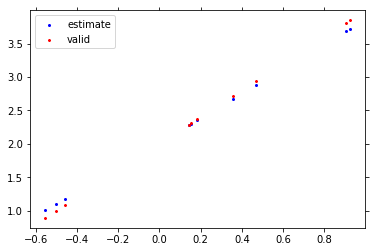

[array([[1.8340337]], dtype=float32), array([2.0234365], dtype=float32)]

In [13]:
plot_estimate = PlotCurrentEstimate(x_valid, y_valid)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                  min_delta=0, patience=100, mode='auto')

model.fit(x_valid, y_valid, batch_size=32, epochs=150,
          validation_data=(x_valid, y_valid),
          callbacks=[ plot_estimate, earlystop]
          )

model.get_weights()